In [1]:
import numpy as np
from scipy.integrate import odeint
import cobra
import os
from os.path import join
data_dir="."
model=cobra.io.read_sbml_model("iCac802.xml")
import matplotlib.pyplot as plt

No handlers could be found for logger "cobra.io.sbml"
cobra\core\reaction.py:437 UserWarning: uppercase AND/OR found in rule 'CAC0368 AND CAC1427' for '<Reaction R0095 at 0x18635b70>'


In [2]:
solution = model.optimize()

model.summary()

IN FLUXES            OUT FLUXES             OBJECTIVES
-------------------  ---------------------  -------------
cpd00027_e  10       cpd11640_e  37.5       Biomass  0.21
cpd00067_e  10       cpd00011_e  25.6
cpd00001_e   4.05    cpd00178_e   8.65
cpd00013_e   2.94    cpd00528_e   0.541
cpd00009_e   0.373   cpd00036_e   0.000947
cpd00048_e   0.0217


In [3]:
def kineticBlock(Glu,But):
    # Parameters
    vGmax,vGmax2, K_Glu, Ki, Kii,K_NH4 = 0.26,0.026, 46, 55.6, 67.5, 0.005
    f_But,f_Act, f_Bth, f_Acn, F_H2 = .424, .908, .977, .908, 0.098
    
    v_Glu=vGmax*Glu/(K_Glu+(Glu/Ki)+Glu*(1+(Bth/Kii)))
    v_NH4 = vGmax2*(NH4)/(K_NH4  + NH4)
    LB_But = -v_Glu*f_But
    LB_Act = -v_Glu*f_Act
    LB_Bth = -v_Glu*f_Bth
    LB_Acn = -v_Glu*f_Acn
    LB_H2 = -v_Glu*F_H2
    #LB_ATP_Ex = m_ATP
    return [v_Glu,v_NH4,LB_But,LB_Act,LB_Bth,LB_Acn,LB_H2]

# Metabolic block
def metabolicBlock(v_Glu,v_NH4,LB_But,LB_Act,LB_Bth,LB_Acn,LB_H2):
    model.reactions.get_by_id("Ex_91").lower_bound = -v_Glu # set flux of glucose
    model.reactions.get_by_id("Ex_91").upper_bound = -v_Glu # set flux of glucose
    model.reactions.get_by_id("Ex_97").lower_bound = -v_NH4 # set flux of glucose
    model.reactions.get_by_id("Ex_97").upper_bound = -v_NH4 # set flux of glucose    
    model.reactions.get_by_id("Ex_96").lower_bound = LB_But #Butirato
    model.reactions.get_by_id("Ex_104").lower_bound = LB_Act #acetato
    model.reactions.get_by_id("Ex_113").lower_bound = LB_Bth #Butanol
    model.reactions.get_by_id("Ex_110").lower_bound = LB_Acn #Acetona
    model.reactions.get_by_id("Ex_116").lower_bound = LB_H2 #Hidrogeno
   
    solution = model.optimize()
    u = solution.objective_value
    v_But = model.reactions.get_by_id("Ex_96").x
    v_Act = model.reactions.get_by_id("Ex_104").x
    v_Bth = model.reactions.get_by_id("Ex_113").x
    v_Acn = model.reactions.get_by_id("Ex_110").x
    v_H2 = model.reactions.get_by_id("Ex_116").x
    return [u, v_But, v_Act, v_Bth, v_Acn, v_H2]
    
# Dynamic block
def f(y,t,params):
    V,VX,VGlu,VNH4,VBut,VAct,VBth,VAcn,VH2 = y # Current values
    F,u, v_Glu, v_NH4, v_But, v_Act, v_Bth, v_Acn, v_H2 = params  # unpack parameters
    Glu_F = 8
    MW_Glu, MW_NH4, MW_But,MW_Act,MW_Bth,MW_Acn, MW_H2 = [0.18,0.096,.046,.060,.072,.090, 0.002] #Molecular weights
    derivs=[F,                  # dV/dt
            u*VX,                # dVX/dt
            F*Glu_F-v_Glu*MW_Glu*(VX), # dVGlu/dt
            -v_NH4*MW_NH4*(VX),
            v_But*MW_But*(VX), # dVBut/dt
            v_Act*MW_Act*(VX), # dVAct/dt
            v_Bth*MW_Bth*(VX), # dVBth/dt
            v_Acn*MW_Acn*(VX), # dVAcn/dt
            v_H2*MW_H2*(VX)] # dVH2/dt
    return derivs
def dynamicBlock(y,params, ti,tf):
    time=np.linspace(ti,tf,100)
 
    soln = odeint(f,y,time,args=(params,))
    soln[soln<0] = 0    
    V=soln[-1,0]

    X,Glu,NH4,But,Act,Bth,Acn,H2=soln[-1,1:9]/V
    return [V,X,Glu,NH4,But,Act,Bth,Acn,H2]  




u_path,V_path,X_path = [],[],[]
Glu_path,NH4_path,But_path,Act_path,Bth_path,Acn_path,H2_path = [],[],[],[],[],[],[]
v_Glu_path,v_NH4_path=[],[]
def savePath(u,V,X,Glu,NH4,But,Act,Bth,Acn,H2,v_Glu,v_NH4):
    global u_path,V_path,X_path
    global Glu_path,NH4_path,But_path,Act_path,Bth_path,Acn_path,H2_path
    global v_Glu_path,v_NH4_path
    u_path += [u]
    V_path += [V]
    X_path += [X]
    Glu_path += [Glu]
    NH4_path += [NH4]
    But_path += [But]
    Act_path += [Act]
    Bth_path += [Bth]
    Acn_path += [Acn]
    H2_path += [H2]
    v_Glu_path += [v_Glu]
    v_NH4_path += [v_NH4]

In [4]:
Glu=60
NH4=8
But,Act,Bth,Acn,H2=[0,0,0,0,0]
V,X=[2,1.5]
F=0
# Running the simulation over time
time=np.linspace(0,250,50)
for i in range(len(time)):
    
    v_Glu,v_NH4,LB_But,LB_Act,LB_Bth,LB_Acn,LB_H2 = kineticBlock(Glu,But)

    u,v_But, v_Act, v_Bth, v_Acn, v_H2 = metabolicBlock(v_Glu,v_NH4,LB_But,LB_Act,LB_Bth,LB_Acn,LB_H2)
 
    if i==len(time)-1: continue
    y = [V,X*V,Glu*V,NH4*V,But*V,Act*V,Bth*V,Acn*V,H2*V]
    params = [F,u,v_Glu,v_NH4, v_But, v_Act, v_Bth, v_Acn,v_H2]
    V,X,Glu, NH4,But,Act,Bth,Acn,H2 = dynamicBlock(y, params, time[i],time[i+1])
    # Save results along the fermentaion path
    savePath(u,V,X,Glu,NH4,But,Act,Bth,Acn,H2,v_Glu, v_H2)

cobra\util\solver.py:416 UserWarning: solver status is 'infeasible'


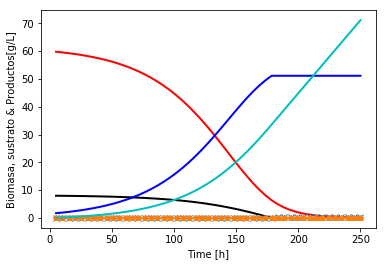

In [13]:
plt.plot(time[1:600],Glu_path,'r',linewidth=2,label='Glucosa')
plt.plot(time[1:600],NH4_path,'k',linewidth=2,label='Sulfato')
plt.plot(time[1:600],X_path,'b',linewidth=2,label='Biomasa')
plt.plot(time[1:600],But_path,'g',linewidth=2,label="Butirato")
plt.plot(time[1:600],Act_path,'y',linewidth=2,label='Acetato')
plt.plot(time[1:600],Bth_path,'x',linewidth=2,label='Butanol')
plt.plot(time[1:600],Acn_path,'p',linewidth=2,label='Acetona')
plt.plot(time[1:600],H2_path,'c',linewidth=2,label='H2')
plt.ylabel('Biomasa, sustrato & Productos[g/L]')
plt.xlabel('Time [h]')
plt.show()

In [6]:
X_path

[1.6977356468657856,
 1.9211723916041494,
 2.173546491516278,
 2.458471671877498,
 2.7799742918943275,
 3.1425290117587004,
 3.5510938895154367,
 4.01114340495996,
 4.528697344611379,
 5.11034276147937,
 5.763245312110142,
 6.495145134702118,
 7.314331029412474,
 8.229585004374902,
 9.250087242907712,
 10.385269245664585,
 11.64460038262586,
 13.037290533868882,
 14.571889255498554,
 16.25576059806332,
 18.094413358681766,
 20.090670778612644,
 22.24367392708496,
 24.547732592304815,
 26.99107068944321,
 29.554564492846406,
 32.21064427200764,
 34.92262033528188,
 37.644787453835825,
 40.32371957479313,
 42.901122835336565,
 45.31838582024702,
 47.52249325282306,
 49.47232824770374,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386,
 51.14382679306386]

In [7]:
H2_path

[0.08551758267731155,
 0.18229587469828887,
 0.29179492498976395,
 0.4156576001984444,
 0.5557306011774367,
 0.7140873440416444,
 0.8930526932664891,
 1.0952294651153984,
 1.323526521395215,
 1.5811881402607524,
 1.8718241730978293,
 2.1994402631122,
 2.5684670989183505,
 2.983787290197772,
 3.4507579663129584,
 3.9752265968277687,
 4.563536802316967,
 5.222520059320122,
 5.959468214775475,
 6.782080650434939,
 7.698378861295687,
 8.716580290484634,
 9.844922772704862,
 11.091431306046967,
 12.463620740262801,
 13.968132213339214,
 15.610308844990419,
 17.39372832139987,
 19.319726991960437,
 21.386970893299623,
 23.59114921971663,
 25.924877670082264,
 28.377888094037658,
 30.93754534852542,
 33.58965459989107,
 36.27031888170562,
 38.95101195997651,
 41.63172900695366,
 44.31246552143739,
 46.99321751680138,
 49.67398160742069,
 52.354755013581226,
 55.035535513200855,
 57.71632136653181,
 60.397111233068074,
 63.077904092409554,
 65.75869917491255,
 68.43949590404263,
 71.1202938501

In [8]:
vv=np.matrix([[1,-2],[3,-1]])
vv

matrix([[ 1, -2],
        [ 3, -1]])

In [9]:
vv[vv<0]=0
vv

matrix([[1, 0],
        [3, 0]])

In [10]:
NH4_path[-15:]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [11]:
NH4_path

[7.979677588936227,
 7.956678467886397,
 7.930655374285106,
 7.90121750483133,
 7.867925492699513,
 7.830285933606117,
 7.787745461515535,
 7.73968439064478,
 7.685409963084782,
 7.6241492721753845,
 7.555041972968785,
 7.477132945359967,
 7.3893651458908876,
 7.290572974423474,
 7.179476595710259,
 7.054677797268691,
 6.914658137223119,
 6.757780340670883,
 6.5822941391098055,
 6.386348006916934,
 6.168008513774762,
 5.925289248329096,
 5.6561914152879,
 5.35875817091843,
 5.031144396713682,
 4.671702721118132,
 4.279084946247597,
 3.8523553948474203,
 3.3911089942575394,
 2.895582509599556,
 2.3667437107866403,
 1.8063439463501092,
 1.2169363876837154,
 0.6019466745358935,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]